# Shape of lob

We will fit linear regression to each order list to get its shape. We will classify these shapes.

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from ast import literal_eval

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '11869'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, include_test=True, length=data_length)

In [4]:
df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df.index = df['datetime']
df = df.sort_index()
print(min(df['datetime']), max(df['datetime']), len(df))
df.dropna(inplace=True)
df.head(5)

2013-09-16 11:39:00 2013-10-30 13:18:00 6000


,datetime,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
datetime,,,,,,,,,,
2013-09-16 11:39:00,2013-09-16 11:39:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2663.0, 202.0), (2664.0, 652.0), (2665.0, 15...",2661.0,2663.0,2662.0,202.0,271.0,1.0,0.145877
2013-09-16 11:42:00,2013-09-16 11:42:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2664.0, 97.0), (2665.0, 894.0), (2666.0, 142...",2663.0,2664.0,2663.5,97.0,121.0,0.0,0.110092
2013-09-16 11:43:00,2013-09-16 11:43:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2662.0, 100.0), (2663.0, 428.0), (2664.0, 83...",2661.0,2662.0,2661.5,100.0,174.0,1.0,0.270073
2013-09-16 11:44:00,2013-09-16 11:44:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2663.0, 338.0), (2664.0, 647.0), (2665.0, 17...",2661.0,2663.0,2662.0,338.0,222.0,1.0,-0.207143
2013-09-16 11:45:00,2013-09-16 11:45:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2664.0, 442.0), (2665.0, 1161.0), (2666.0, 1...",2661.0,2664.0,2662.5,442.0,420.0,1.0,-0.025522


In [5]:
def fit_linear_regression_for_row(row, column_name='ask', should_plot=False):
    d_bid = np.array([literal_eval(row.get(column_name))][0])
    reg = LinearRegression(normalize=True)
    X = np.vstack([np.array(range(1, len(d_bid) + 1)), np.log(np.array(range(1, len(d_bid) + 1)))]).T
    weights = np.zeros(len(d_bid))
    weights[0] = 100
    weights[1] = 10
    weights[2] = 1
    
    y = (d_bid[:, 0] * d_bid[:, 1]) * weights # / np.sum((d_bid[:, 0] * d_bid[:, 1]))
    reg.fit(X, y)
    if should_plot:
        plt.plot(np.dot(X, reg.coef_.T) + reg.intercept_, label='sf')
        plt.plot(y, label='y')
        plt.legend()
    return reg

def fit_linear_regression(df: pd.DataFrame) -> LinearRegression:
    reg_coefs = []
    for i, row in df.iterrows():
        reg_bid = fit_linear_regression_for_row(row, column_name='bid')
        reg_ask = fit_linear_regression_for_row(row, column_name='ask')
        reg_coefs.append({
            'bid_coef_0': reg_bid.coef_[0], 'bid_coef_1': reg_bid.coef_[1], 'bid_intercept': reg_bid.intercept_,
            'ask_coef_0': reg_ask.coef_[0], 'ask_coef_1': reg_ask.coef_[1], 'ask_intercept': reg_ask.intercept_
        })
    df = df.join(pd.DataFrame(reg_coefs, index=df.index))
    return df
df = fit_linear_regression(df)
df_cv = fit_linear_regression(df_cv)
df.head()

,datetime,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,ask_coef_0,ask_coef_1,ask_intercept,bid_coef_0,bid_coef_1,bid_intercept
datetime,,,,,,,,,,,,,,,,
2013-09-16 11:39:00,2013-09-16 11:39:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2663.0, 202.0), (2664.0, 652.0), (2665.0, 15...",2661.0,2663.0,2662.0,202.0,271.0,1.0,0.145877,3.157108e+06,-3.277204e+07,3.997997e+07,9.803411e+06,-1.134412e+08,1.470397e+08
2013-09-16 11:42:00,2013-09-16 11:42:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2664.0, 97.0), (2665.0, 894.0), (2666.0, 142...",2663.0,2664.0,2663.5,97.0,121.0,0.0,0.110092,1.705899e+06,-1.893524e+07,2.484347e+07,8.527161e+06,-1.056598e+08,1.436537e+08
2013-09-16 11:43:00,2013-09-16 11:43:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2662.0, 100.0), (2663.0, 428.0), (2664.0, 83...",2661.0,2662.0,2661.5,100.0,174.0,1.0,0.270073,1.481331e+06,-1.618601e+07,2.059922e+07,9.803411e+06,-1.134412e+08,1.470397e+08
2013-09-16 11:44:00,2013-09-16 11:44:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2663.0, 338.0), (2664.0, 647.0), (2665.0, 17...",2661.0,2663.0,2662.0,338.0,222.0,1.0,-0.207143,5.143018e+06,-5.237183e+07,6.244694e+07,9.803411e+06,-1.134412e+08,1.470397e+08
2013-09-16 11:45:00,2013-09-16 11:45:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 3...","[(2664.0, 442.0), (2665.0, 1161.0), (2666.0, 1...",2661.0,2664.0,2662.5,442.0,420.0,1.0,-0.025522,6.853003e+06,-7.012618e+07,8.410204e+07,9.803411e+06,-1.134412e+08,1.470397e+08


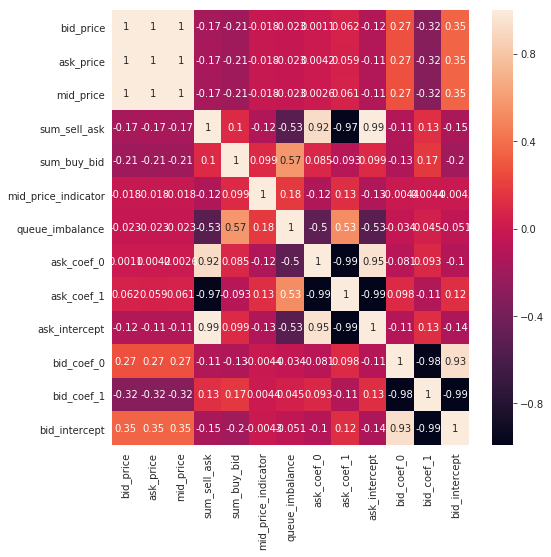

In [6]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)

## Let's try to fit SVM

In [7]:
def svc(clf, df, df_cv, columns):
    X = df[columns]
    y = df['mid_price_indicator']
    clf.fit(X, y)
    pred = clf.predict(X)
    pred_cv = clf.predict(df_cv[columns])
    return roc_auc_score(y, pred), roc_auc_score(df_cv['mid_price_indicator'], pred_cv)

In [8]:
def plot_results(clf, df, df_cv, plot_title=''):
    x_columns = {}
    x_columns['ask_bid_'] = [c for c in df.columns if 'ask_' in c or 'bid_' in c]
    x_columns['ask_bid_coef_'] = [c for c in df.columns if 'ask_coef' in c or 'bid_coef' in c]
    x_columns['queue_im_ask_bid_'] = [c for c in df.columns if 'queue_im' in c or 'ask_' in c or 'bid_' in c]
    x_columns['queue_imb'] = [c for c in df.columns if 'queue_im'  in c]
    x_columns['intercept'] = [c for c in df.columns if 'intercept' in c]

    results = []
    titles = []
    for title, x_cols in x_columns.items():
        res = svc(clf, df, df_cv, x_cols)
        titles.append(title)
        results.append({'train': res[0], 'cv': res[1]})
    df_res = pd.DataFrame(results, index=titles)
    df_res.to_csv(plot_title + '.csv')
    df_res[['train', 'cv']].plot(kind='bar')
    plt.legend(loc='lower left')
    plt.ylim(0, 1)
    plt.title(plot_title)
    plt.savefig(plot_title + '.png')

In [9]:
%%capture

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clfs = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.1),
    'MLPClassifier': MLPClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianProcessClassifier': GaussianProcessClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegressionCV': LogisticRegressionCV(),
    'SVC': SVC(kernel='rbf'),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'SVC_100_100': SVC(kernel='rbf', C=100, gamma=100),
    'SVC_100_1': SVC(kernel='rbf', C=100, gamma=1),
    'SVC_1_100': SVC(kernel='rbf', C=1, gamma=100),
    'SVC_01_01': SVC(kernel='rbf', C=0.1, gamma=0.1),
}
for title, clf in clfs.items():
    print(title)
    plot_results(clf, df, df_cv, plot_title=title)

In [10]:
df_res = pd.DataFrame(columns=['train', 'cv', 'classifier', 'features'])
for title, clf in clfs.items():
    df_res_temp = pd.read_csv(title + '.csv')
    df_res_temp['classifier'] = title
    df_res = df_res.append(df_res_temp)
    
df_res.sort_values(by='cv', ascending=False)

,Unnamed: 0,classifier,cv,features,train
3,queue_imb,SVC_1_100,0.563920,NaN,0.582132
3,queue_imb,SVC_100_100,0.563437,NaN,0.582132
3,queue_imb,AdaBoostClassifier,0.562177,NaN,0.583925
3,queue_imb,LogisticRegressionCV,0.561881,NaN,0.581054
3,queue_imb,GaussianNB,0.561807,NaN,0.577922
3,queue_imb,QuadraticDiscriminantAnalysis,0.561807,NaN,0.577922
3,queue_imb,GaussianProcessClassifier,0.561548,NaN,0.578581
3,queue_imb,SVC_01_01,0.561436,NaN,0.579142
3,queue_imb,SVC,0.561362,NaN,0.578687
3,queue_imb,MLPClassifier,0.561362,NaN,0.578511
